One of competitions on Kaggle, "House Prices", is about predicting sale prices of houses. The dataset contains  79 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa. We are going to approach this challenge with three regression methods: Random Forest, XGboost and Neural Network.

In [46]:
import numpy as np 
import pandas as pd 


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from keras.layers import Dropout
from sklearn.model_selection import RandomizedSearchCV

/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv
/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt


Let us start with loading the data.

In [21]:
dane=pd.read_csv('../input/house-prices-advanced-regression-techniques/train.csv',index_col='Id')
dane.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


We can notice that this dataset is not complete. We are going to investigate missing values.

In [22]:
# Get names of columns with missing values
cols_with_missing = [col for col in dane.columns
                     if dane[col].isnull().any()]
print(cols_with_missing)

['LotFrontage', 'Alley', 'MasVnrType', 'MasVnrArea', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Electrical', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature']


In [23]:
dane[cols_with_missing].isnull().sum()

LotFrontage      259
Alley           1369
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64

We can notice that a lot of missing values are not really missing but mean that some features like garage are not available for those houses. 

At this moment we are going to get rid of two variables: GarageYrBlt and LotFrontage. They have some missing values that are way too hard to impute properly.

Imputation of NaNs of the rest is quite simple. We put "None" instead of NaN in every categorical variable except Electrical. We put 0 in MasVnrArea.  

In [24]:
imputer_None = SimpleImputer(strategy='constant',fill_value='None')
imputer_MasVnrArea = SimpleImputer(strategy='constant',fill_value=0)
imputer_Electrical = SimpleImputer(strategy='most_frequent')

dane.Alley=imputer_None.fit_transform(dane['Alley'].values.reshape(-1,1))[:,0]
dane.MasVnrType=imputer_None.fit_transform(dane['MasVnrType'].values.reshape(-1,1))[:,0]
dane.MasVnrArea=imputer_MasVnrArea.fit_transform(dane['MasVnrArea'].values.reshape(-1,1))[:,0]
dane.BsmtQual=imputer_None.fit_transform(dane['BsmtQual'].values.reshape(-1,1))[:,0]
dane.BsmtCond=imputer_None.fit_transform(dane['BsmtCond'].values.reshape(-1,1))[:,0]
dane.BsmtExposure=imputer_None.fit_transform(dane['BsmtExposure'].values.reshape(-1,1))[:,0]
dane.BsmtFinType1=imputer_None.fit_transform(dane['BsmtFinType1'].values.reshape(-1,1))[:,0]
dane.BsmtFinType2=imputer_None.fit_transform(dane['BsmtFinType2'].values.reshape(-1,1))[:,0]
dane.Electrical=imputer_Electrical.fit_transform(dane['Electrical'].values.reshape(-1,1))[:,0]
dane.FireplaceQu=imputer_None.fit_transform(dane['FireplaceQu'].values.reshape(-1,1))[:,0]
dane.GarageType=imputer_None.fit_transform(dane['GarageType'].values.reshape(-1,1))[:,0]
dane.GarageFinish=imputer_None.fit_transform(dane['GarageFinish'].values.reshape(-1,1))[:,0]
dane.GarageQual=imputer_None.fit_transform(dane['GarageQual'].values.reshape(-1,1))[:,0]
dane.GarageCond=imputer_None.fit_transform(dane['GarageCond'].values.reshape(-1,1))[:,0]
dane.PoolQC=imputer_None.fit_transform(dane['PoolQC'].values.reshape(-1,1))[:,0]
dane.Fence=imputer_None.fit_transform(dane['Fence'].values.reshape(-1,1))[:,0]
dane.MiscFeature=imputer_None.fit_transform(dane['MiscFeature'].values.reshape(-1,1))[:,0]

In [25]:
dane=dane.drop(['GarageYrBlt', 'LotFrontage'], axis=1)

We should also check if there are any outlier. We can see some anomalies in LotArea variable.

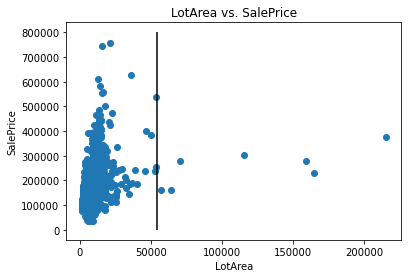

In [26]:
plt.scatter(dane.LotArea, dane.SalePrice)
plt.vlines(54000,ymin=0,ymax=800000)
plt.title('LotArea vs. SalePrice')
plt.xlabel('LotArea')
plt.ylabel('SalePrice')
plt.show() 

We are going to delete the last 7 points on the right side of the plot. 

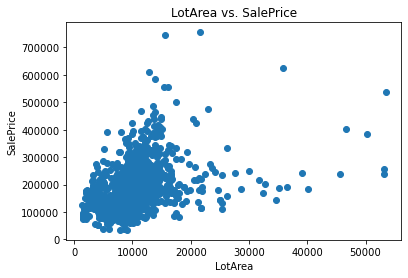

In [27]:
dane=dane[dane.LotArea<54000]
plt.scatter(dane.LotArea, dane.SalePrice)
plt.title('LotArea vs. SalePrice')
plt.xlabel('LotArea')
plt.ylabel('SalePrice')
plt.show() 

Now we are going to see some more variables with outliers.

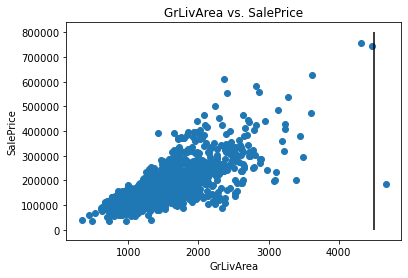

In [28]:
plt.scatter(dane.GrLivArea, dane.SalePrice)
plt.vlines(4500,ymin=0,ymax=800000)
plt.title('GrLivArea vs. SalePrice')
plt.xlabel('GrLivArea')
plt.ylabel('SalePrice')
plt.show()
dane=dane[dane.GrLivArea<4500]

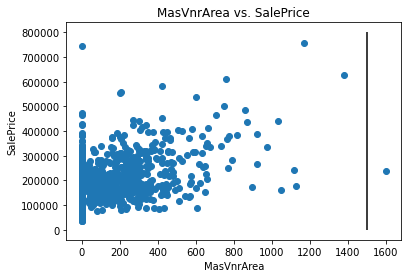

In [29]:
plt.scatter(dane['MasVnrArea'], dane.SalePrice)
plt.vlines(1500,ymin=0,ymax=800000)
plt.title('MasVnrArea vs. SalePrice')
plt.xlabel('MasVnrArea')
plt.ylabel('SalePrice')
plt.show()
dane=dane[dane.MasVnrArea<1500]

Points that are to the right of the black lines are deleted. Now let's see some more plots.

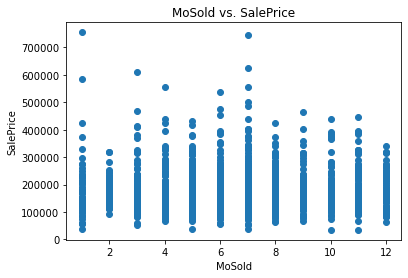

In [30]:
plt.scatter(dane.MoSold, dane.SalePrice)
plt.title('MoSold vs. SalePrice')
plt.xlabel('MoSold')
plt.ylabel('SalePrice')
plt.show()

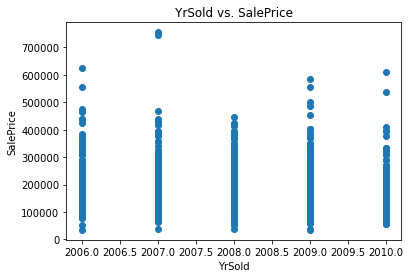

In [31]:
plt.scatter(dane.YrSold, dane.SalePrice)
plt.title('YrSold vs. SalePrice')
plt.xlabel('YrSold')
plt.ylabel('SalePrice')
plt.show()

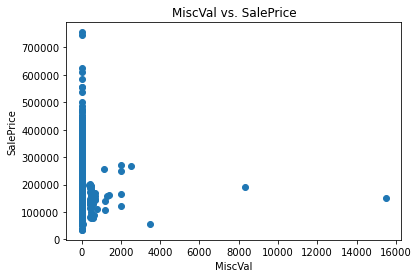

In [32]:
plt.scatter(dane.MiscVal, dane.SalePrice)
plt.title('MiscVal vs. SalePrice')
plt.xlabel('MiscVal')
plt.ylabel('SalePrice')
plt.show()

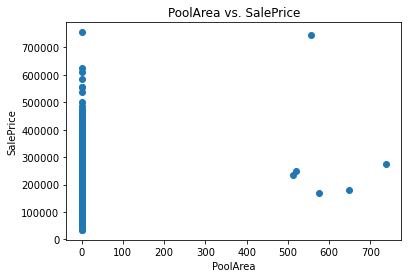

In [33]:
plt.scatter(dane.PoolArea, dane.SalePrice)
plt.title('PoolArea vs. SalePrice')
plt.xlabel('PoolArea')
plt.ylabel('SalePrice')
plt.show()

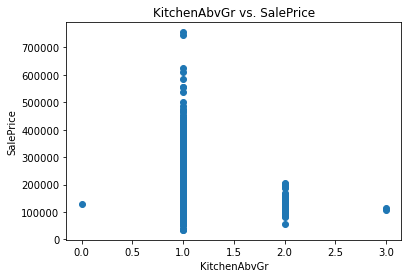

In [34]:
plt.scatter(dane.KitchenAbvGr, dane.SalePrice)
plt.title('KitchenAbvGr vs. SalePrice')
plt.xlabel('KitchenAbvGr')
plt.ylabel('SalePrice')
plt.show()

We are going to get rid of MoSold (month sold), YrSold (year sold), MiscVal (value of miscellaneous feature), PoolArea, KitchenAbvGr and PoolQC (pool quality). Those variables do not bring any information.

In [35]:
dane=dane.drop(['MiscVal','PoolArea','PoolQC', 'KitchenAbvGr','MoSold', 'YrSold'], axis=1)

We do not have much data so we are going to delete categorical variables that have more than 9 unique values.

In [36]:
categorical_cols = [cname for cname in dane.columns if
                    dane[cname].nunique() < 10 and 
                    dane[cname].dtype == "object"]


numerical_cols = [cname for cname in dane.columns if 
                dane[cname].dtype in ['int64', 'float64']]

cols = categorical_cols + numerical_cols
dane=dane[cols]

Now we split the data to training and testing sets, normalize numerical variables and use one hot encoding for categorical ones. We also transform target variable using logarithm to reduce the variability.

In [37]:
y = np.log1p(dane.SalePrice)
dane.drop(['SalePrice'], axis=1, inplace=True)

# Break off validation set from training data
X_train_full, X_valid_full, y_train, y_valid = train_test_split(dane, y, 
                                                                train_size=0.8, test_size=0.2,
                                                                random_state=0)



from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
numerical_cols.remove('SalePrice')


X_train_full.reset_index(inplace = True, drop = True) 
X_valid_full.reset_index(inplace = True, drop = True) 


scaler.fit(X_train_full[numerical_cols])

X_train_full_scale=pd.DataFrame(scaler.transform(X_train_full[numerical_cols]))
X_train_full_scale.columns=numerical_cols

X_valid_full_scale=pd.DataFrame(scaler.transform(X_valid_full[numerical_cols]))
X_valid_full_scale.columns=numerical_cols

X_train_full=pd.concat([X_train_full[categorical_cols], X_train_full_scale], axis=1)
X_valid_full=pd.concat([X_valid_full[categorical_cols], X_valid_full_scale], axis=1)

X_train_full=pd.get_dummies(X_train_full)
X_valid_full=pd.get_dummies(X_valid_full)

We still have too much variables. We are going to fit a Random Forest model with a lot of trees and see which variables are important.

In [38]:
RF_Var_selection = RandomForestRegressor(n_estimators=10000, max_features = 150, random_state=0)
RF_Var_selection.fit(X_train_full,y_train)

RandomForestRegressor(max_features=150, n_estimators=10000, random_state=0)

In [39]:
def plot_feature_importance(importance,names,model_type):

    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(10,80))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    
    
    #Add chart labels
    plt.title(model_type + ' FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')
    
    return(fi_df['feature_names'][0:20])

It seems that top 20 variables is a good idea.

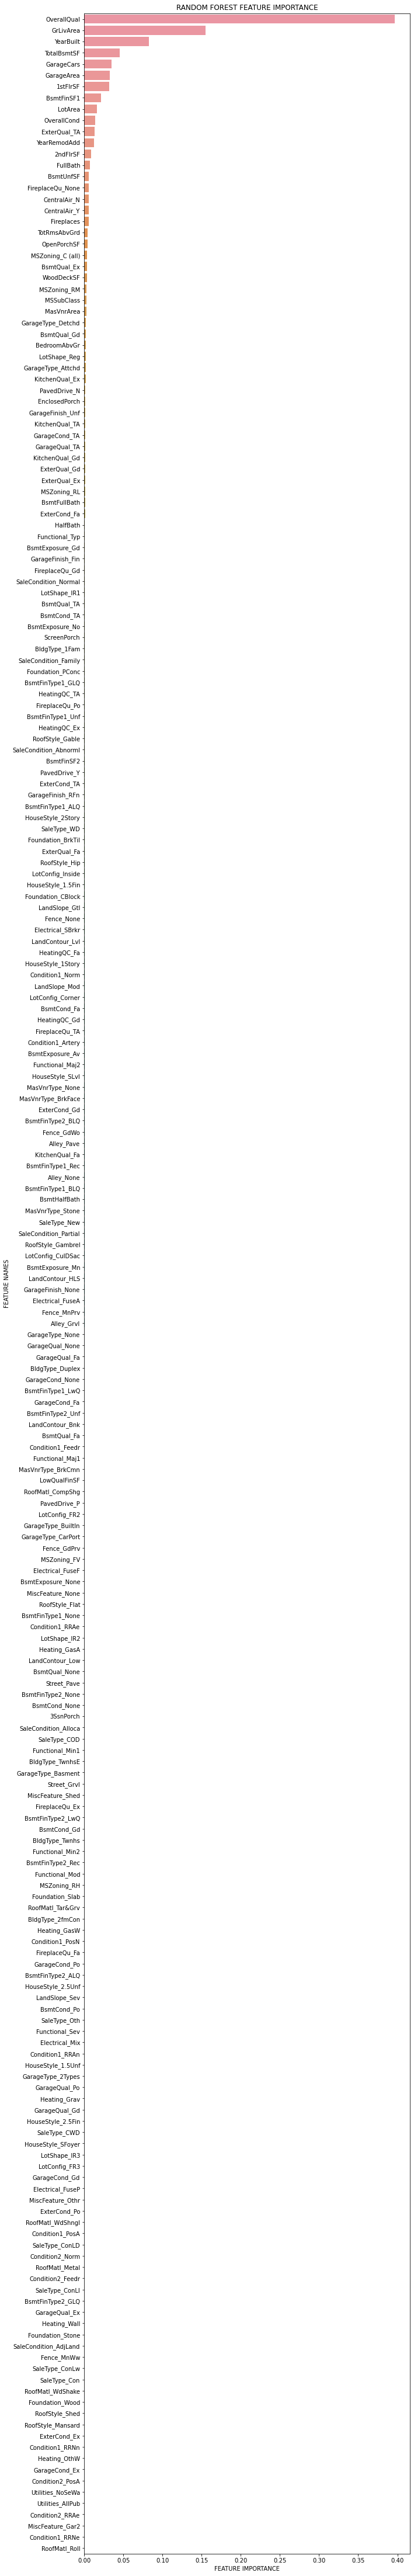

In [40]:
best_20_variables=plot_feature_importance(RF_Var_selection.feature_importances_,X_train_full.columns,'RANDOM FOREST')

X_train=X_train_full[best_20_variables].copy()
X_valid=X_valid_full[best_20_variables].copy()

In [41]:
print(best_20_variables)

2           OverallQual
14            GrLivArea
4             YearBuilt
10          TotalBsmtSF
22           GarageCars
23           GarageArea
11             1stFlrSF
7            BsmtFinSF1
1               LotArea
3           OverallCond
102        ExterQual_TA
5          YearRemodAdd
12             2ndFlrSF
17             FullBath
9             BsmtUnfSF
173    FireplaceQu_None
152        CentralAir_N
153        CentralAir_Y
21           Fireplaces
20         TotRmsAbvGrd
Name: feature_names, dtype: object


We start with Random Forest. To find good set of parameters for the forest we will check every option defined in the grid below. 

In [44]:
paramsForest = {
        'min_samples_split': [2, 5, 10],
        'max_features': [2,4,6,8,10,12,14,16,18,20]
        }

In [47]:
folds = 5
param_comb = 30

RaFor=RandomForestRegressor(n_estimators=1000,min_samples_split=2, max_features = 20, random_state=1001)
random_search=RandomizedSearchCV(RaFor, paramsForest, n_jobs=1, cv=folds, n_iter=param_comb, scoring='neg_root_mean_squared_error',random_state=1001)


random_search.fit(X_train, y_train)

print('\n Best hyperparameters:')
print(random_search.best_params_)
results = pd.DataFrame(random_search.cv_results_)


 Best hyperparameters:
{'min_samples_split': 2, 'max_features': 8}


In [49]:
BestRF=RandomForestRegressor(n_estimators=1000,min_samples_split=2, max_features = 8, random_state=1001)
BestRF.fit(X_train,y_train)
RFpred = BestRF.predict(X_valid) 


mse_RF = mean_squared_error(RFpred,y_valid) 
rmse_RF=np.sqrt(mse_RF)
print(rmse_RF)

0.13800053602817314


The best set of parameters is min_samples_split equal to 2 and max_features equal to 8. The RMSE is around 0.1380 (with taking log of target variable). 

Now let us consider XGboost model. For start let us see the RMSE with default options.

In [51]:
XGbReg = XGBRegressor(n_estimators=1000, learning_rate=0.01, random_state=1001) 


XGbReg.fit(X_train,y_train) 


XGpred = XGbReg.predict(X_valid)


mse_XG = mean_squared_error(XGpred,y_valid) 
rmse_XG=np.sqrt(mse_XG)
print(rmse_XG)

0.13395554595754725


We will try to improve this score with different set of hyperparameters. To find better set we are going to perform random grid search. Our search will be based on the cross validation method as we did before with Random Forest.

In [53]:
paramsXG = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0,0.5,1, 5],
        'subsample': [0.7, 1.0],
        'colsample_bytree': [0.7, 1.0],
        'max_depth': [ 4, 5,6,7],
        'reg_lambda' : [1,2,3],
        'eta' : [0.3,0.6]
        }

In [54]:
folds = 5
param_comb = 150

random_search = RandomizedSearchCV(XGbReg, paramsXG, n_jobs=1, cv=folds, n_iter=param_comb, scoring='neg_root_mean_squared_error',random_state=1001)

random_search.fit(X_train, y_train)

print('\n Best hyperparameters:')
print(random_search.best_params_)
results = pd.DataFrame(random_search.cv_results_)


 Best hyperparameters:
{'subsample': 0.7, 'reg_lambda': 2, 'min_child_weight': 5, 'max_depth': 7, 'gamma': 0, 'eta': 0.3, 'colsample_bytree': 0.7}


We plug in the best parameters into the formula.

In [55]:
XGbest=XGBRegressor(n_estimators=1000, learning_rate=0.01, subsample= 0.7,reg_lambda=2, min_child_weight= 5, max_depth= 7, gamma= 0,eta=0.3, colsample_bytree= 0.7)
XGbest.fit(X_train,y_train) 


XGbestpred = XGbest.predict(X_valid) 


mse_XGbest = mean_squared_error(XGbestpred,y_valid) 
rmse_XGbest=np.sqrt(mse_XGbest)
print(rmse_XGbest)

0.13266818620608006


Comparing the values of RMSE, we can notice that parameters from random search improved the result.

The last part of this notebook is about using Neural Network. We are going to use keras.

We start with defining base model for another random search of grid. Our parameters will be: numbers of neurons in layers, dropout, used optimizer method, number of epochs and batch size. We are not going to change activation function, number of layers and regularization parameters (l1, l2).

In [56]:
def create_model(optimizer='adam',dropout=0.1,hidden_layers=[4,3,2,1]):
    # create model
    model = Sequential()
    model.add(Dense(hidden_layers[0], input_dim=X_train.shape[1], activation='relu'))
    model.add(Dropout(dropout))
    model.add(Dense(hidden_layers[1], activation='relu'))
    model.add(Dropout(dropout))
    model.add(Dense(hidden_layers[2], activation='relu'))
    model.add(Dropout(dropout))
    model.add(Dense(hidden_layers[3]))
    model.compile(loss='mean_squared_error', optimizer=optimizer,metrics=['mse'])
    return model

RegNN = KerasRegressor(build_fn=create_model, epochs=100, batch_size=10, verbose=0)


In [86]:
paramsNN = {
        'batch_size': [30,50,100,200,500],
        'epochs': [ 200,300,500],
        'dropout': [0.0, 0.1,0.3],
        'hidden_layers': [(75, 50,25,1), (50, 30,10, 1), (40, 30,20, 1)],
        'optimizer': ['SGD', 'adam']
        }

In [87]:
folds = 3
param_comb = 50

random_search = RandomizedSearchCV(RegNN, paramsNN, n_jobs=1, cv=folds, n_iter=param_comb, scoring='neg_root_mean_squared_error',random_state=1001,verbose=2)

random_search.fit(X_train, y_train)


Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] optimizer=SGD, hidden_layers=(75, 50, 25, 1), epochs=300, dropout=0.0, batch_size=500 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  optimizer=SGD, hidden_layers=(75, 50, 25, 1), epochs=300, dropout=0.0, batch_size=500, total=   2.5s
[CV] optimizer=SGD, hidden_layers=(75, 50, 25, 1), epochs=300, dropout=0.0, batch_size=500 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.5s remaining:    0.0s


[CV]  optimizer=SGD, hidden_layers=(75, 50, 25, 1), epochs=300, dropout=0.0, batch_size=500, total=   3.2s
[CV] optimizer=SGD, hidden_layers=(75, 50, 25, 1), epochs=300, dropout=0.0, batch_size=500 
[CV]  optimizer=SGD, hidden_layers=(75, 50, 25, 1), epochs=300, dropout=0.0, batch_size=500, total=   2.6s
[CV] optimizer=SGD, hidden_layers=(40, 30, 20, 1), epochs=200, dropout=0.3, batch_size=100 
[CV]  optimizer=SGD, hidden_layers=(40, 30, 20, 1), epochs=200, dropout=0.3, batch_size=100, total=   2.8s
[CV] optimizer=SGD, hidden_layers=(40, 30, 20, 1), epochs=200, dropout=0.3, batch_size=100 
[CV]  optimizer=SGD, hidden_layers=(40, 30, 20, 1), epochs=200, dropout=0.3, batch_size=100, total=   2.8s
[CV] optimizer=SGD, hidden_layers=(40, 30, 20, 1), epochs=200, dropout=0.3, batch_size=100 
[CV]  optimizer=SGD, hidden_layers=(40, 30, 20, 1), epochs=200, dropout=0.3, batch_size=100, total=   2.8s
[CV] optimizer=adam, hidden_layers=(40, 30, 20, 1), epochs=200, dropout=0.1, batch_size=30 
[CV] 

[CV]  optimizer=adam, hidden_layers=(40, 30, 20, 1), epochs=500, dropout=0.1, batch_size=500, total=   3.4s
[CV] optimizer=adam, hidden_layers=(40, 30, 20, 1), epochs=500, dropout=0.1, batch_size=500 
[CV]  optimizer=adam, hidden_layers=(40, 30, 20, 1), epochs=500, dropout=0.1, batch_size=500, total=   3.5s
[CV] optimizer=adam, hidden_layers=(50, 30, 10, 1), epochs=500, dropout=0.3, batch_size=200 
[CV]  optimizer=adam, hidden_layers=(50, 30, 10, 1), epochs=500, dropout=0.3, batch_size=200, total=   4.5s
[CV] optimizer=adam, hidden_layers=(50, 30, 10, 1), epochs=500, dropout=0.3, batch_size=200 
[CV]  optimizer=adam, hidden_layers=(50, 30, 10, 1), epochs=500, dropout=0.3, batch_size=200, total=   4.7s
[CV] optimizer=adam, hidden_layers=(50, 30, 10, 1), epochs=500, dropout=0.3, batch_size=200 
[CV]  optimizer=adam, hidden_layers=(50, 30, 10, 1), epochs=500, dropout=0.3, batch_size=200, total=   4.6s
[CV] optimizer=SGD, hidden_layers=(75, 50, 25, 1), epochs=200, dropout=0.0, batch_size=3

[CV]  optimizer=adam, hidden_layers=(50, 30, 10, 1), epochs=500, dropout=0.0, batch_size=500, total=   3.2s
[CV] optimizer=adam, hidden_layers=(50, 30, 10, 1), epochs=500, dropout=0.0, batch_size=500 
[CV]  optimizer=adam, hidden_layers=(50, 30, 10, 1), epochs=500, dropout=0.0, batch_size=500, total=   3.4s
[CV] optimizer=adam, hidden_layers=(50, 30, 10, 1), epochs=200, dropout=0.1, batch_size=50 
[CV]  optimizer=adam, hidden_layers=(50, 30, 10, 1), epochs=200, dropout=0.1, batch_size=50, total=   4.7s
[CV] optimizer=adam, hidden_layers=(50, 30, 10, 1), epochs=200, dropout=0.1, batch_size=50 
[CV]  optimizer=adam, hidden_layers=(50, 30, 10, 1), epochs=200, dropout=0.1, batch_size=50, total=   6.1s
[CV] optimizer=adam, hidden_layers=(50, 30, 10, 1), epochs=200, dropout=0.1, batch_size=50 
[CV]  optimizer=adam, hidden_layers=(50, 30, 10, 1), epochs=200, dropout=0.1, batch_size=50, total=   5.0s
[CV] optimizer=SGD, hidden_layers=(50, 30, 10, 1), epochs=500, dropout=0.1, batch_size=200 
[C

[CV]  optimizer=adam, hidden_layers=(75, 50, 25, 1), epochs=200, dropout=0.0, batch_size=50, total=   6.0s
[CV] optimizer=adam, hidden_layers=(75, 50, 25, 1), epochs=200, dropout=0.0, batch_size=50 
[CV]  optimizer=adam, hidden_layers=(75, 50, 25, 1), epochs=200, dropout=0.0, batch_size=50, total=   5.3s
[CV] optimizer=adam, hidden_layers=(40, 30, 20, 1), epochs=200, dropout=0.3, batch_size=500 
[CV]  optimizer=adam, hidden_layers=(40, 30, 20, 1), epochs=200, dropout=0.3, batch_size=500, total=   3.0s
[CV] optimizer=adam, hidden_layers=(40, 30, 20, 1), epochs=200, dropout=0.3, batch_size=500 
[CV]  optimizer=adam, hidden_layers=(40, 30, 20, 1), epochs=200, dropout=0.3, batch_size=500, total=   2.0s
[CV] optimizer=adam, hidden_layers=(40, 30, 20, 1), epochs=200, dropout=0.3, batch_size=500 
[CV]  optimizer=adam, hidden_layers=(40, 30, 20, 1), epochs=200, dropout=0.3, batch_size=500, total=   1.9s
[CV] optimizer=adam, hidden_layers=(75, 50, 25, 1), epochs=300, dropout=0.1, batch_size=500

[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed: 16.0min finished


RandomizedSearchCV(cv=3,
                   estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x7f72c105e710>,
                   n_iter=50, n_jobs=1,
                   param_distributions={'batch_size': [30, 50, 100, 200, 500],
                                        'dropout': [0.0, 0.1, 0.3],
                                        'epochs': [200, 300, 500],
                                        'hidden_layers': [(75, 50, 25, 1),
                                                          (50, 30, 10, 1),
                                                          (40, 30, 20, 1)],
                                        'optimizer': ['SGD', 'adam']},
                   random_state=1001, scoring='neg_root_mean_squared_error',
                   verbose=2)

In [105]:
print('\n Best hyperparameters:')
print(random_search.best_params_)
results = pd.DataFrame(random_search.cv_results_)


 Best hyperparameters:
{'optimizer': 'SGD', 'hidden_layers': (75, 50, 25, 1), 'epochs': 500, 'dropout': 0.0, 'batch_size': 30}


In [89]:
def create_model_final(optimizer='SGD',dropout=0,hidden_layers=[75, 50, 25, 1]):
    # create model
    model = Sequential()
    model.add(Dense(hidden_layers[0], input_dim=X_train.shape[1], activation='relu'))
    model.add(Dropout(dropout))
    model.add(Dense(hidden_layers[1], activation='relu'))
    model.add(Dropout(dropout))
    model.add(Dense(hidden_layers[2], activation='relu'))
    model.add(Dropout(dropout))
    model.add(Dense(hidden_layers[3]))
    model.compile(loss='mean_squared_error', optimizer=optimizer,metrics=['mse'])
    return model



RegNN_final = KerasRegressor(build_fn=create_model_final, epochs=500, batch_size=30, verbose=0)

In [95]:
RegNN_final.fit(X_train,y_train) 


RegNNpred = RegNN_final.predict(X_valid) 

mse_RegNNbest = mean_squared_error(RegNNpred,y_valid) 
rmse_RegNNbest=np.sqrt(mse_RegNNbest)
print(rmse_RegNNbest)

0.1286496625173735


The best set of parameters picked by grind search is optimizer: 'SGD', hidden_layers= (75, 50, 25, 1), epochs= 500, dropout= 0 and  batch_size= 30. Let us see the average RMSE of this model on 10 tries.

In [104]:
RMSENN=[]
for i in range(10):
    RegNN_final.fit(X_train,y_train)
    RegNNpred = RegNN_final.predict(X_valid)  
    mse_RegNNbest = mean_squared_error(RegNNpred,y_valid) 
    rmse_RegNNbest=np.sqrt(mse_RegNNbest)
    RMSENN.append(rmse_RegNNbest)
print(RMSENN)
print(np.mean(RMSENN))

[0.12745583903866808, 0.12740882953881189, 0.12304781762593198, 0.1269378930336724, 0.12617529495984656, 0.13257711891618956, 0.12783154704281624, 0.15187020519830702, 0.12676522183284086, 0.1249934422432263]
0.12950632094303108


It seems that neural network is the best way to predict prices of houses in our setting. We should be aware that model tuning in this notebook can be improved by taking different grids.